In [39]:

import os

#os.environ['HF_HOME'] = '/data/users/ugarg/hf/hf_cache/'
os.environ['TRANSFORMERS_CACHE'] = '/data/users/ugarg/hf/hf_cache/'
os.environ['CUDA_VISIBLE_DEVICES']='1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pandarallel import pandarallel
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pandarallel.initialize(progress_bar=False)
from torch.nn.functional import one_hot


from collections import Counter

from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import torch
import numpy as np
import random
from transformers import AdamW, AutoTokenizer,  AutoModel
from torch.nn.functional import one_hot
from collections import Counter
def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)
import joblib



INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [40]:
def format_table(df):
    df['labels'] = df['mr'].apply(lambda x: x.split('(',1)[0])
    df = df.drop('mr', 1)
    return df

In [41]:
train = pd.read_csv('../data/viggo-train.csv')
val = pd.read_csv('../data/viggo-valid.csv')
test = pd.read_csv('../data/viggo-test.csv')
train, test, valid = format_table(train), format_table(test), format_table(val)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5103 entries, 0 to 5102
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ref     5103 non-null   object
 1   labels  5103 non-null   object
dtypes: object(2)
memory usage: 79.9+ KB


In [ ]:
train[]

In [6]:
train.labels.value_counts()

inform                 2379
give_opinion            531
verify_attribute        531
request                 330
recommend               315
request_explanation     312
confirm                 309
suggest                 303
request_attribute        93
Name: labels, dtype: int64

In [7]:
def show_sample(df, num_rows):
    for i in range(num_rows):
        idx = np.random.choice(len(df))
        ref = df.loc[idx]['ref']
        da = df.loc[idx]['labels']
        #domain = df.loc[idx]['domain']
        print('-'*50)
        print(ref)
        print(da)
        #print(domain)
        print('-'*50)

print("\nSample Data: ")
print(show_sample(train, 3))



Sample Data: 
--------------------------------------------------
I was wondering, do you also like the 2010 games developed by Days of Wonder, such as Small World 2?
suggest
--------------------------------------------------
--------------------------------------------------
You mentioned disliking Dance Dance Revolution Universe 3. Are you just not about music games on Xbox?
verify_attribute
--------------------------------------------------
--------------------------------------------------
Why do you feel that the third person games made by Square are excellent?
request_explanation
--------------------------------------------------
None


In [8]:

DROPOUT = 0.3
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
MAX_LENGTH = 100
BATCH_SIZE = 64
EARLY_STOPPING_LIMIT = 5
DEVICE = 'cuda:0'

save_checkpoint_path = 'checkpoints/best_model.pt'
resume_from_checkpoint = True




##################
#   tokenizer
##################


from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
print(f'\nLoading Tokenizer: {model_checkpoint} ...')
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)




Loading Tokenizer: bert-base-cased ...


In [9]:


####################################
#   Create Pytorch Datasets
####################################

class TrainDataset:
    def __init__(self, train, tokenizer, max_length):
        self.train = train
        self.tokenizer = tokenizer
        self.source_column = 'ref'
        self.label_column = 'labels'
        self.max_length = max_length
        self.build_vocab()
    
    def __len__(self):
        return len(self.train)
    
    def build_vocab(self,):
         #get vocab
        self.stoi = {'request': 0,
                     'inform': 1,
                     'suggest': 2,
                     'request_attribute': 3,
                     'verify_attribute': 4,
                     'confirm': 5,
                     'give_opinion': 6,
                     'request_explanation': 7,
                     'recommend': 8}
        self.itos = {j:i for i,j in self.stoi.items()}
        
        self.num_class = len(self.itos)
        
        
    def __getitem__(self, idx):
        tokenized_source_text = self.tokenizer(self.train[self.source_column].loc[idx], truncation=True, padding=True, max_length = self.max_length)
        label = self.stoi[self.train[self.label_column][idx]]
        #one_hot_labels = one_hot(torch.tensor(label), num_classes = self.num_class)
        tokenized_source_text['label'] = label
        return tokenized_source_text

    
class ValDataset:
    def __init__(self, train_dataset, val, tokenizer, max_length):
        self.stoi = train_dataset.stoi
        self.itos = train_dataset.itos
        self.num_class = len(self.stoi)
        self.val = val
        self.tokenizer = tokenizer
        self.source_column = 'ref'
        self.label_column = 'labels'
        self.max_length = max_length
    def __len__(self):
        return len(self.val)

        
    def __getitem__(self, idx):
        tokenized_source_text = self.tokenizer(self.val[self.source_column].loc[idx], truncation=True, padding=True, max_length = self.max_length)
        label = self.stoi[self.val[self.label_column][idx]]
        tokenized_source_text['label'] = label
        return tokenized_source_text
        
        
print(f'\nCreating Pytorch Datasets and Loaders...')

print(f'\nKeeping max length: {MAX_LENGTH}\nBatch Size: {BATCH_SIZE}')




Creating Pytorch Datasets and Loaders...

Keeping max length: 100
Batch Size: 64


In [10]:

train_dataset = TrainDataset(train, tokenizer, max_length = MAX_LENGTH)
val_dataset = ValDataset(train_dataset, val, tokenizer, max_length = MAX_LENGTH)
test_dataset = ValDataset(train_dataset, test, tokenizer, max_length = MAX_LENGTH)


In [11]:
train_dataset.itos

{0: 'request',
 1: 'inform',
 2: 'suggest',
 3: 'request_attribute',
 4: 'verify_attribute',
 5: 'confirm',
 6: 'give_opinion',
 7: 'request_explanation',
 8: 'recommend'}

In [12]:
train_dataset.stoi

{'request': 0,
 'inform': 1,
 'suggest': 2,
 'request_attribute': 3,
 'verify_attribute': 4,
 'confirm': 5,
 'give_opinion': 6,
 'request_explanation': 7,
 'recommend': 8}

In [13]:

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn = data_collator,
    batch_size=BATCH_SIZE,
)
val_dataloader = DataLoader(
    val_dataset, collate_fn = data_collator, batch_size=BATCH_SIZE
)

test_dataloader = DataLoader(
    test_dataset, collate_fn = data_collator, batch_size=BATCH_SIZE
)

print("\nShape of batch: ", next(iter(train_dataloader))['input_ids'].shape)


Shape of batch:  torch.Size([64, 73])


In [14]:


####################################
#   Create Model Class
####################################


class Model(torch.nn.Module):
    def __init__(self, model_checkpoint, train_dataset, dropout, device):
        super().__init__()
        self.base = AutoModel.from_pretrained(
                model_checkpoint,
                #id2label=id2label,
                #label2id=label2id,
                )
        """
        Uncomment if want to use adapter
        #         self.base.add_adapter('adap')

        #         self.base.train_adapter("adap")
        #         self.base.set_active_adapters("adap")

        Uncomment if want to unfreeze specific layers
                # c = 0
                # for name, param in self.base.named_parameters():
                #     c+=1
                #     if c <= 100:
                #         param.requires_grad = False

        """
        self.stoi = train_dataset.stoi
        self.itos = train_dataset.itos
        self.device = device
        self.fc = torch.nn.Linear(self.base.config.hidden_size, len(self.stoi))
        
        self.dropout = torch.nn.Dropout(dropout)
        self.loss_fn = torch.nn.CrossEntropyLoss()    
        
        
        
    
    def forward(self, batch, mode = 'Train'):
        batch.to(self.device)
        self.base.to(self.device)
        self.fc.to(self.device)
        _ , pools = self.base(input_ids=batch['input_ids'],
                      attention_mask=batch['attention_mask'],
                      token_type_ids=batch['token_type_ids'],
                       return_dict=False)
        # print(hidden.shape)
        # print(pools.shape)

        if mode == 'Train':
            
            out = self.fc(self.dropout(pools))

            actual = batch['labels']
            loss = self.loss_fn(out, actual)

            return loss, out, actual
        else:
            
            out = self.fc(self.dropout(pools))
            return out




In [15]:

####################################
#   Load Model
####################################

print(f'\nUsing device {DEVICE} for training...')

model = Model(model_checkpoint, train_dataset, DROPOUT, DEVICE)
model.to(DEVICE)

####################################
#   Create Optimizer
####################################
print(f'\nCreating optimizer with Learning Rate: {LEARNING_RATE}')

from torch.optim import AdamW, Adam

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)


Using device cuda:0 for training...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Creating optimizer with Learning Rate: 0.0001


In [16]:
# # In[8]:




# from transformers import get_scheduler, get_cosine_with_hard_restarts_schedule_with_warmup
# print(f'\nTraining for {NUM_EPOCHS} epochs with early stopping set to {EARLY_STOPPING_LIMIT}\n\n')

# num_train_epochs = NUM_EPOCHS
# num_update_steps_per_epoch = len(train_dataloader)
# num_training_steps = num_train_epochs * num_update_steps_per_epoch

# # lr_scheduler = get_scheduler(
# #     "linear",
# #     optimizer=optimizer,
# #     num_warmup_steps=500,
# #     num_training_steps=num_training_steps,
# # )
# lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
#     optimizer=optimizer,
#     num_warmup_steps=500,
#     num_training_steps=num_training_steps,
# )


# # In[9]:


# ####################################
# #   Create Checkpoint Builder
# ####################################

# def checkpoint_builder(model, optimizer, epoch, train_dataset, save_checkpoint_path):
#     """
#     desc:
#         creates checkpoint for the model
#     params:
#         model: trained model
#         optimizer
#         criterion: loss fn
#         epoch: checkpoint epoch
#         model_params: hyperparams of model
#         data_module: object of DataModule => contains the datasets and vocabulary
#         save_checkpoint_path: path to save checkpoint. Include checkpoint name
#     """
    
#     torch.save({'model_state_dict': model.state_dict(),
#                         'optim_state_dict':optimizer.state_dict(),
                        
#                         'epoch': epoch, 
                        
#                         'source_stoi': train_dataset.stoi,
#                         'source_itos': train_dataset.itos,
#                        }, save_checkpoint_path)


# # In[10]:




# from tqdm.auto import tqdm
# import torch

# progress_bar = tqdm(range(num_training_steps))
# early_stopping_counter = 0
# early_stopping_limit = EARLY_STOPPING_LIMIT
# best_valid_loss = float('inf')
# for epoch in range(num_train_epochs):
#     train_loss=0
#     valid_loss =0
    

    
#     print(f"[Epoch {epoch} / {num_train_epochs}]")
#     # Training
#     model.train()
#     for batch_idx, batch in enumerate(train_dataloader):
#         loss, out, actual = model(batch)
#         #loss = outputs.loss
#         loss.backward(loss)#, retain_graph = True)

#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         train_loss+= ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
#         progress_bar.update(1)
#         progress_bar.set_postfix(loss = train_loss)
        
    
    
#     # Evaluation
#     model.eval()
#     for batch in val_dataloader:
#         with torch.no_grad():
#             loss, out, actual = model(batch)


#         labels = actual
#         predictions = out
        

#         valid_loss+= ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
        

#     print('\nEpoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
#             epoch, 
#             train_loss,
#             valid_loss
#             ))

#     #early stopping, checkpointing
#     if valid_loss < best_valid_loss:
#         early_stopping_counter = 0
#         best_valid_loss = valid_loss
#         #create checkpoint
#         print("Loss improved saving checkpoint... ")
#         checkpoint_builder(model, optimizer, epoch, train_dataset, save_checkpoint_path)

#     else:
#         early_stopping_counter += 1
#         if early_stopping_counter >= early_stopping_limit:
#             print(f'\nLoss did not reduce for last {early_stopping_counter} epochs. Stopped training..')
#             break


# # In[ ]:





In [17]:


# ### Testing

# In[ ]:



if resume_from_checkpoint:
        print('Loading Checkpoint ...')
        checkpoint = torch.load(save_checkpoint_path, map_location=DEVICE)
        source_stoi = checkpoint['source_stoi']
        source_itos = checkpoint['source_itos']                
        print('Setting Models state to checkpoint...')
        #assert checkpoint['model_params'] == model_params
        model.load_state_dict(checkpoint['model_state_dict'])
        print('Model state set.')
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        print('Optimizer state set.')


Loading Checkpoint ...
Setting Models state to checkpoint...
Model state set.
Optimizer state set.


In [18]:
source_stoi

{'request': 0,
 'inform': 1,
 'suggest': 2,
 'request_attribute': 3,
 'verify_attribute': 4,
 'confirm': 5,
 'give_opinion': 6,
 'request_explanation': 7,
 'recommend': 8}

In [19]:
list(source_stoi.keys())

['request',
 'inform',
 'suggest',
 'request_attribute',
 'verify_attribute',
 'confirm',
 'give_opinion',
 'request_explanation',
 'recommend']

In [20]:
train_dataset.stoi

{'request': 0,
 'inform': 1,
 'suggest': 2,
 'request_attribute': 3,
 'verify_attribute': 4,
 'confirm': 5,
 'give_opinion': 6,
 'request_explanation': 7,
 'recommend': 8}

In [21]:
train_dataset[1]

{'input_ids': [101, 12120, 3740, 131, 3237, 5455, 1110, 170, 4799, 3915, 1342, 1115, 1108, 1308, 1107, 1368, 119, 1109, 1342, 1110, 1907, 1113, 8905, 117, 12335, 117, 1105, 7054, 117, 1105, 1122, 1144, 1126, 142, 16396, 2064, 21632, 1158, 1104, 142, 1275, 116, 113, 1111, 6064, 1275, 1105, 26694, 114, 119, 1438, 117, 1122, 1110, 1136, 1870, 1907, 1112, 170, 15144, 117, 11735, 117, 1137, 6603, 1836, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'label': 1}


Validation Results:
Accuracy: 0.9957983193277311
                     precision    recall  f1-score   support

            request       0.98      1.00      0.99        45
             inform       1.00      1.00      1.00       297
            suggest       1.00      0.98      0.99        45
  request_attribute       1.00      0.95      0.98        21
   verify_attribute       0.98      1.00      0.99        81
            confirm       1.00      1.00      1.00        51
       give_opinion       1.00      1.00      1.00        84
request_explanation       1.00      1.00      1.00        39
          recommend       1.00      0.98      0.99        51

           accuracy                           1.00       714
          macro avg       0.99      0.99      0.99       714
       weighted avg       1.00      1.00      1.00       714



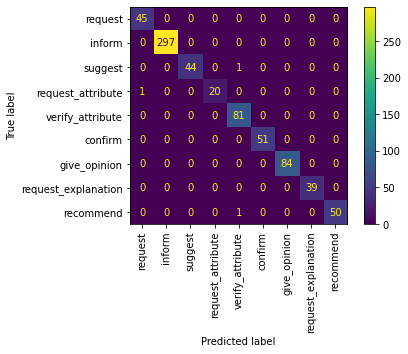


Test Results:
Accuracy: 0.9879963065558633
                     precision    recall  f1-score   support

            request       0.96      0.99      0.97        75
             inform       0.99      1.00      0.99       324
            suggest       0.99      1.00      1.00       102
  request_attribute       0.97      0.94      0.96        36
   verify_attribute       1.00      1.00      1.00       138
            confirm       1.00      1.00      1.00        90
       give_opinion       0.99      0.97      0.98       135
request_explanation       0.97      0.99      0.98        99
          recommend       1.00      0.95      0.98        84

           accuracy                           0.99      1083
          macro avg       0.99      0.98      0.98      1083
       weighted avg       0.99      0.99      0.99      1083



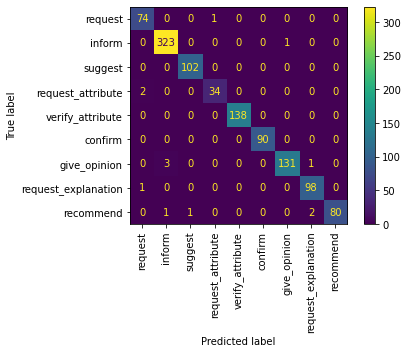

In [22]:




#prints the examples that were wrongly predicted
#prints the Accuracy and returns it
#print the classification report
def get_accuracy(dataloader, print_errors = False):
    acc = []
    preds = []
    acts = []
    for batch_idx, batch in enumerate(dataloader):
        
        _, out, actual = model(batch)
        out = torch.argmax(out, axis = 1)
        out = out.cpu().numpy()
        actual = actual.cpu().numpy()
        
        acc.append([i == j for i, j in zip(out,actual)])
        preds.append(out.tolist())
        acts.append(actual.tolist())
        del(out, actual,_,batch)
    
    print(f'Accuracy: {np.mean(sum(acc,[]))}')
    
    from sklearn.metrics import classification_report

    label_names = list(source_stoi.keys())
    print(classification_report(sum(acts,[]), sum(preds,[]),target_names=label_names))
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    dis = ConfusionMatrixDisplay(confusion_matrix(sum(acts,[]), sum(preds,[])), display_labels=label_names)
    dis.plot(xticks_rotation=90)
    plt.show()
    

# In[15]:
#model.eval()
# model.to(DEVICE)
print('\nValidation Results:')
get_accuracy(val_dataloader, print_errors = True)
print('\nTest Results:')
get_accuracy(test_dataloader)








In [23]:
# prompt_df = pd.read_csv('../test_files/GPT-NEO_viggo_test_2DA_100 - GPT-NEO_viggo_test_2DA_100.csv')

# prompt_df = prompt_df[['MR', 'Candiate','best ref','is it related to DA']].dropna().reset_index(drop=True)

# prompt_df.columns = ['mr', 'candidate', 'best_ref', 'related']

# def predict(col):
#     df = prompt_df.copy()
#     tokenized_data = tokenizer(df[col].values.tolist())
#     tokenized_data = data_collator(tokenized_data)

#     out = model(tokenized_data, mode = 'Test')
#     probs = torch.nn.functional.softmax(out, dim = 1).detach().cpu().numpy()
#     pred = out.argmax(dim = 1).cpu().numpy()
#     pred = [train_dataset.itos[i] for i in pred]
#     probs = [i.max() for i in probs]

#     df[f'{col}_pred'] = 1
#     df[f'{col}_prob'] = 1
#     for i in range(len(df)):
#         df.loc[i,f'{col}_pred'] = pred[i]
#         df.loc[i,f'{col}_prob'] = probs[i]
#     return df

# prompt_df = predict('candidate')
# prompt_df = predict('best_ref')
# prompt_df['actual'] = prompt_df['mr'].apply(lambda x: x.split('|')[0].split('=')[0].strip())

# print(prompt_df.apply(lambda x: 1 if x['candidate_pred'] == x['actual'] else 0,axis=1).value_counts())

# prompt_df.to_csv('GPT-NEO_viggo_test_2DA_100_da_predictions.csv')

In [24]:
# prompt_df['check'] = prompt_df.candidate.apply(lambda x: 1 if 'did' in x else 0)

In [25]:
# prompt_df[prompt_df.check==1]

In [26]:
# prompt_df = pd.read_csv('../test_files/viggo-test-specific-10examples-new-format-1-100 - viggo-test-specific-10examples-1-100.csv')

# prompt_df = prompt_df[['MR', 'Candidate','best ref',' DA (perfect  3, 2, 1 means not really at all)']].dropna().reset_index(drop=True)

# prompt_df.columns = ['mr', 'candidate', 'best_ref', 'related']

# def predict(col):
#     df = prompt_df.copy()
#     tokenized_data = tokenizer(df[col].values.tolist())
#     tokenized_data = data_collator(tokenized_data)

#     out = model(tokenized_data, mode = 'Test')
#     probs = torch.nn.functional.softmax(out, dim = 1).detach().cpu().numpy()
#     pred = out.argmax(dim = 1).cpu().numpy()
#     pred = [train_dataset.itos[i] for i in pred]
#     probs = [i.max() for i in probs]

#     df[f'{col}_pred'] = 1
#     df[f'{col}_prob'] = 1
#     for i in range(len(df)):
#         df.loc[i,f'{col}_pred'] = pred[i]
#         df.loc[i,f'{col}_prob'] = probs[i]
#     return df

# prompt_df = predict('candidate')
# prompt_df = predict('best_ref')
# prompt_df['actual'] = prompt_df['mr'].apply(lambda x: x.split('|')[0].split('=')[0].split(':')[1].strip())
# print(prompt_df.apply(lambda x: 1 if x['candidate_pred'] == x['actual'] else 0,axis=1).value_counts())
# prompt_df.to_csv('viggo-test-specific-10examples-new-format-1-100 - viggo-test-specific-10examples-1-100.csv')

In [27]:
# prompt_df.related.value_counts()

In [28]:
# print(prompt_df.apply(lambda x: 1 if x['candidate_pred'] == x['actual'] else 0,axis=1).value_counts())

In [29]:
# print(prompt_df.apply(lambda x: 1 if x['candidate_pred'] == x['actual'] and x['related']!=3 else 0,axis=1).value_counts())

In [30]:
# prompt_df = pd.read_csv('../test_files/viggo_test_5_shuffle_output - cc-clean.csv')

# prompt_df = prompt_df[['mr', 'generated']].reset_index(drop=True)

# prompt_df.columns = ['mr', 'candidate']

# def predict(col):
#     df = prompt_df.copy()
#     tokenized_data = tokenizer(df[col].values.tolist())
#     tokenized_data = data_collator(tokenized_data)

#     out = model(tokenized_data, mode = 'Test')
#     probs = torch.nn.functional.softmax(out, dim = 1).detach().cpu().numpy()
#     pred = out.argmax(dim = 1).cpu().numpy()
#     pred = [train_dataset.itos[i] for i in pred]
#     probs = [i.max() for i in probs]

#     df[f'{col}_pred'] = 1
#     df[f'{col}_prob'] = 1
#     for i in range(len(df)):
#         df.loc[i,f'{col}_pred'] = pred[i]
#         df.loc[i,f'{col}_prob'] = probs[i]
#     return df

# prompt_df = predict('candidate')
# #prompt_df = predict('best_ref')
# prompt_df['actual'] = prompt_df['mr'].apply(lambda x: x.split('|')[0].split('=')[0].strip())
# print(prompt_df.apply(lambda x: 1 if x['candidate_pred'] == x['actual'] else 0,axis=1).value_counts())
# prompt_df.to_csv('viggo_test_5_shuffle_output - cc-clean.csv')

In [31]:
# prompt_df.apply(lambda x: 1 if x['candidate_pred'] == x['actual'] else 0, axis=1).value_counts()

In [32]:
# prompt_df[['mr', 'candidate_pred', 'candidate_prob']].to_csv('viggo_test_5_shuffle_output - cc-clean.csv')

In [33]:
# prompt_df = pd.read_csv('../test_files/viggo_test_5_shuffle_output - cc-clean.csv')

In [34]:
# prompt_df[prompt_df.candidate=='Do you like playing Diablo II?']

In [35]:
# prompt_df = pd.read_csv('../test_files/viggo_test_custom25_output - viggo_test_custom_output.csv')


In [36]:
# prompt_df[['mr', 'generated']].info()

In [37]:
# prompt_df = pd.read_csv('../test_files/viggo_test_custom25_output - viggo_test_custom_output.csv')

# prompt_df = prompt_df[['mr','generated']].dropna().reset_index(drop=True)



# def predict(col):
#     df = prompt_df.copy()
#     tokenized_data = tokenizer(df[col].values.tolist())
#     tokenized_data = data_collator(tokenized_data)
    
    
#     out = model(tokenized_data, mode = 'Test')
#     probs = torch.nn.functional.softmax(out, dim = 1).detach().cpu().numpy()
#     pred = out.argmax(dim = 1).cpu().numpy()
#     pred = [train_dataset.itos[i] for i in pred]
#     probs = [i.max() for i in probs]

#     df[f'{col}_pred'] = 1
#     df[f'{col}_prob'] = 1
#     for i in range(len(df)):
#         df.loc[i,f'{col}_pred'] = pred[i]
#         df.loc[i,f'{col}_prob'] = probs[i]
#     return df

# prompt_df = predict('generated')
# #prompt_df = predict('best_ref')
# prompt_df['actual'] = prompt_df['mr'].apply(lambda x: x.split('|')[0].split('=')[0].strip())

# print(prompt_df.apply(lambda x: 1 if x['candidate_pred'] == x['actual'] else 0,axis=1).value_counts())

# prompt_df.to_csv('../test_files/viggo_test_custom25_output - viggo_test_custom_output.csv')

In [38]:
prompt_df = pd.read_csv('../test_files/viggo_test_custom25_output - viggo_test_custom_output.csv')

prompt_df = prompt_df[['mr','generated']].dropna().reset_index(drop=True)



def predict(col):
    df = prompt_df.copy()
    tokenized_data = tokenizer(df[col].values.tolist())
    tokenized_data = data_collator(tokenized_data)
    print(tokenized_data)
    outs = []
    
    for i in range(0,len(tokenized_data['input_ids']), 100):
        out = model(tokenized_data['input_ids'][i:i+100], mode = 'Test')
        outs.append(out)
    
    
    probs = torch.nn.functional.softmax(out, dim = 1).detach().cpu().numpy()
    pred = out.argmax(dim = 1).cpu().numpy()
    pred = [train_dataset.itos[i] for i in pred]
    probs = [i.max() for i in probs]

    df[f'{col}_pred'] = 1
    df[f'{col}_prob'] = 1
    for i in range(len(df)):
        df.loc[i,f'{col}_pred'] = pred[i]
        df.loc[i,f'{col}_prob'] = probs[i]
    return df

prompt_df = predict('generated')
#prompt_df = predict('best_ref')
prompt_df['actual'] = prompt_df['mr'].apply(lambda x: x.split('|')[0].split('=')[0].strip())

print(prompt_df.apply(lambda x: 1 if x['candidate_pred'] == x['actual'] else 0,axis=1).value_counts())

prompt_df.to_csv('../test_files/viggo_test_custom25_output - viggo_test_custom_output.csv')

{'input_ids': tensor([[  101,  2091,  1128,  ...,     0,     0,     0],
        [  101,  1573,   117,  ...,     0,     0,     0],
        [  101,  3270, 11906,  ...,     0,     0,     0],
        ...,
        [  101,  2091,  1128,  ...,     0,     0,     0],
        [  101,  4373,  1128,  ...,     0,     0,     0],
        [  101,  5718,  1128,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


IndexError: too many indices for tensor of dimension 2